In [1]:
import csv
import functools
import gzip
import pandas as pd
import json
import tempfile
import gzip
import json
import tqdm
import mlflow
import torch.nn.functional as F

from gensim import corpora
from gensim.parsing import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from tqdm.notebook import tqdm, trange
from gensim.models import KeyedVectors
from torch.utils.data import Dataset, DataLoader, IterableDataset
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import bz2

from sklearn.metrics import classification_report,accuracy_score,f1_score,balanced_accuracy_score

import warnings
warnings.filterwarnings("ignore") 

In [2]:
class MeLiChallengeDataset(IterableDataset):
    def __init__(self, path, transform=None):
        self.dataset_path = path
        self.transform = transform

    def __iter__(self):
        with gzip.open(self.dataset_path, "rt") as fh:
            for l in fh:
                data = json.loads(l)
                item = {
                    "data": data['title'],
                    "target": data['target']
                }
                if self.transform:
                    yield self.transform(item)
                else:
                    yield item

dataset = MeLiChallengeDataset("./AprendizajeProfundo/data/meli-challenge-2019/spanish.train.jsonl.gz")
dataloader = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=0)
dataiter = iter(dataloader)
print(f"Sample batch:\n{next(dataiter)}")

Sample batch:
{'data': ['Casita Muñecas Barbies Pintadas', 'Neceser Cromado Holográfico ', 'Funda Asiento A Medida D20 Chevrolet', 'Embrague Ford Focus One 1.8 8v Td (90cv) Desde 01-99'], 'target': tensor([0, 1, 2, 3])}


In [3]:
# x, y = next(dataiter)
# x,y
# for i in y:
#     print(i)

In [4]:
## Carga de datos como DF de Pandas para un analisis exploratorio inicial:
train_df = pd.concat([x for x in pd.read_json('./AprendizajeProfundo/data/meli-challenge-2019/spanish.train.jsonl.gz', lines=True, chunksize=100000)], ignore_index=True)
train_df.head()

,language,label_quality,title,category,split,tokenized_title,data,target,n_labels,size
0,spanish,reliable,Casita Muñecas Barbies Pintadas,DOLLHOUSES,train,"[casita, muñecas, barbies, pintadas]","[50001, 2, 50000, 3]",0,632,4895280
1,spanish,unreliable,Neceser Cromado Holográfico,TOILETRY_BAGS,train,"[neceser, cromado, holográfico]","[6, 4, 5]",1,632,4895280
2,spanish,unreliable,Funda Asiento A Medida D20 Chevrolet,CAR_SEAT_COVERS,train,"[funda, asiento, medida, chevrolet]","[9, 7, 10, 8]",2,632,4895280
3,spanish,unreliable,Embrague Ford Focus One 1.8 8v Td (90cv) Desde...,AUTOMOTIVE_CLUTCH_KITS,train,"[embrague, ford, focus, one]","[11, 13, 12, 14]",3,632,4895280
4,spanish,unreliable,Bateria Panasonic Dmwbcf10 Lumix Dmc-fx60n Dmc...,CAMERA_BATTERIES,train,"[bateria, panasonic, dmwbcf, lumix, dmc, fxn, ...","[15, 19, 17, 18, 16, 1, 1, 1]",4,632,4895280


In [5]:
train_df_short = train_df[:2000000]

In [6]:
validation_df = pd.concat([x for x in pd.read_json('./AprendizajeProfundo/data/meli-challenge-2019/spanish.validation.jsonl.gz', lines=True, chunksize=100000)], ignore_index=True)

In [7]:
# category_freq = Df['category'].value_counts()
# category_freq = pd.DataFrame({'Qntd':  category_freq.values, 'Percentage': category_freq.apply(lambda x: '{0} %'.format(x*100/train_size))})
# print(category_freq.head(8), '\n...\n')
# print(category_freq.tail(8))
# print('\n', category_freq['Qntd'].describe())

#### (Se pega la imagen para no tener que correr el codigo porque demora demasiado)

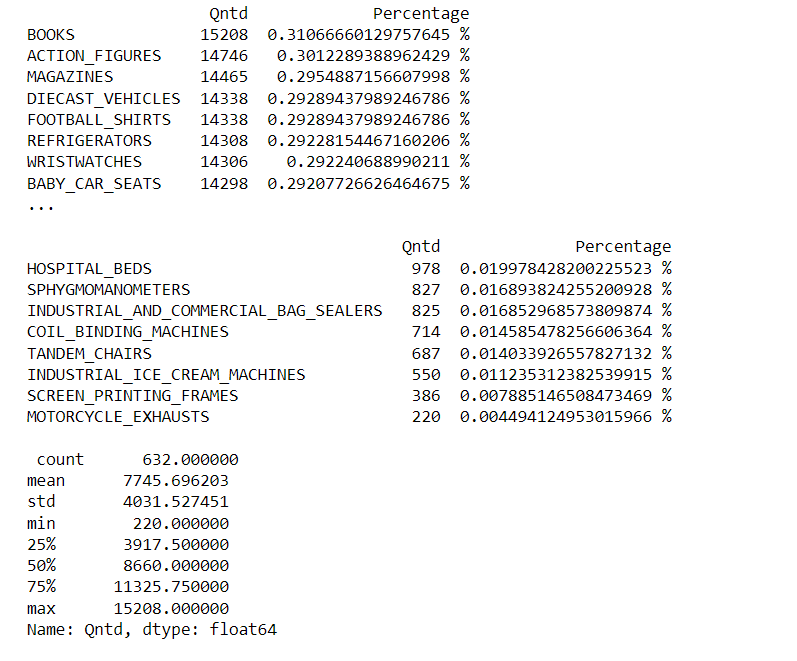

Contamos con 632 categorias a clasificar, siendo las que mas aparecen Books, action figures y magazines. Sin embargo, no cuentan con un gran peso sobre el total de categorias por lo que podriamos concluir que el Dataset esta bastante normalizado entre las categorias a predecir. 

In [8]:
# Df['data'].hist(bins=30) # no puede cargarse el histograma

In [9]:
# Cantidad de categorias a predecir:
# Qtarget = Df.category.unique()
# print(Qtarget[:10])
# print(len(Qtarget))

In [10]:
# eval_model = pd.read_json("./AprendizajeProfundo/data/meli-challenge-2019/spanish.test.jsonl.gz", lines=True)
# eval_model.head() 
#Se puede observar que el archivo de validacion tiene la columna data

In [11]:
test_df = pd.concat([x for x in pd.read_json('./AprendizajeProfundo/data/meli-challenge-2019/spanish.test.jsonl.gz', lines=True, chunksize=100000)], ignore_index=True)

In [12]:
class RawDataProcessor:
    def __init__(self, 
                 dataset, 
                 ignore_header=True, 
                 filters=None, 
                 vocab_size=50000):
        if filters:
            self.filters = filters
        else:
            self.filters = [ #We set some filters
                lambda s: s.lower(),
                preprocessing.strip_tags,
                preprocessing.strip_punctuation,
                preprocessing.strip_multiple_whitespaces,
                preprocessing.strip_numeric,
                preprocessing.remove_stopwords,
                preprocessing.strip_short,
            ]

        self.dictionary = corpora.Dictionary(
            dataset["title"].map(self._preprocess_string).tolist()
        )
        

        self.dictionary.filter_extremes(no_below=2, no_above=1, keep_n=vocab_size)
        self.dictionary.compactify()

        self.dictionary.patch_with_special_tokens({
            "[PAD]": 0,
            "[UNK]": 1 
        })
        
        self.idx_to_target = sorted(dataset["category"].unique())
        self.target_to_idx = {t: i for i, t in enumerate(self.idx_to_target)}
        

    def _preprocess_string(self, string):
        return preprocessing.preprocess_string(string, filters=self.filters)

    def _sentence_to_indices(self, sentence):
        return self.dictionary.doc2idx(sentence, unknown_word_index=1)
    
    def encode_data(self, data):
        return self._sentence_to_indices(self._preprocess_string(data))
    
    def encode_target(self, target):
        return self.target_to_idx[target]
    
    def __call__(self, item):
        #Encodeamos tanto los datos como los targets, diferenciandos los casos cuando son strings y cuando no
        if isinstance(item["data"], str): 
            data = self.encode_data(item["data"])
        else:
            data = [self.encode_data(d) for d in item["data"]]
        
        if isinstance(item["target"], str):
            target = self.encode_target(item["target"])
        else:
            target = [self.encode_target(t) for t in item["target"]]
        
        return {
            "data": data,
            "target": target
        }

In [13]:
class MyDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
    
    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, item):
        if torch.is_tensor(item):
            item = item.to_list()
        
        item = {
            "data": self.dataset.loc[item, "title"],
            "target": self.dataset.loc[item, "category"]
        }
        
        if self.transform:
            item = self.transform(item)
        
        return item

In [14]:
preprocess_train = RawDataProcessor(train_df_short)
train_dataset = MyDataset(train_df_short, transform=preprocess_train)


preprocess_validation = RawDataProcessor(validation_df)
validation_dataset = MyDataset(validation_df, transform=preprocess_validation)


preprocess_test = RawDataProcessor(test_df)
test_dataset = MyDataset(test_df, transform=preprocess_test)

print(f"Datasets loaded with {len(train_dataset)}")

print(f"training elements and {len(train_dataset)} test elements")
print(f"validation elements and {len(validation_dataset)} test elements")
print(f"test elements and {len(test_dataset)} test elements")

print(f"Sample train element:\n{train_dataset[0]}")

Datasets loaded with 2000000
training elements and 2000000 test elements
validation elements and 1223820 test elements
test elements and 63680 test elements
Sample train element:
{'data': [50001, 2, 50000, 3], 'target': 188}


In [15]:
class PadSequences:
    def __init__(self, pad_value=0, max_length=None, min_length=1):
        assert max_length is None or min_length <= max_length
        self.pad_value = pad_value
        self.max_length = max_length
        self.min_length = min_length

    def __call__(self, items):
        data, target = list(zip(*[(item["data"], item["target"]) for item in items]))
        seq_lengths = [len(d) for d in data]

        if self.max_length:
            max_length = self.max_length
            seq_lengths = [min(self.max_length, l) for l in seq_lengths]
        else:
            max_length = max(self.min_length, max(seq_lengths))

        data = [d[:l] + [self.pad_value] * (max_length - l)
                for d, l in zip(data, seq_lengths)]
            
        return {
            "data": torch.LongTensor(data),
            "target": torch.FloatTensor(target)
        }

In [16]:
pad_sequences = PadSequences()

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True,collate_fn=pad_sequences, drop_last=False, num_workers=0)
validation_loader = DataLoader(validation_dataset, batch_size=128, shuffle=True,collate_fn=pad_sequences, drop_last=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False,collate_fn=pad_sequences, drop_last=False, num_workers=0)

### Modelo 1

In [22]:
class MLPmodelo(nn.Module):
    def __init__(self, 
                 pretrained_embeddings_path, 
                 dictionary,
                 vector_size,
                 freeze_embedings):
        super().__init__()
        embeddings_matrix = torch.randn(len(dictionary), vector_size)
        embeddings_matrix[0] = torch.zeros(vector_size)
        with bz2.open(pretrained_embeddings_path, "rt") as fh:
            for line in fh:
                word, vector = line.strip().split(None, 1)
                if word in dictionary.token2id:
                    embeddings_matrix[dictionary.token2id[word]] =\
                        torch.FloatTensor([float(n) for n in vector.split()])
        self.embeddings = nn.Embedding.from_pretrained(embeddings_matrix,
                                                       freeze=freeze_embedings,
                                                       padding_idx=0)
        
        self.hidden1 = nn.Linear(vector_size, 256)
        self.hidden2 = nn.Linear(256, 256)
        self.hidden3 = nn.Linear(256, 256)
        self.output = nn.Linear(256, 632)
        self.vector_size = vector_size
    
    def forward(self, x):
        x = self.embeddings(x)
        x = torch.mean(x, dim=1)
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        x = self.output(x)
        
        
        return x

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [19]:
class MyClassifier(nn.Module):
    def __init__(self, 
                 pretrained_embeddings_path, 
                 dictionary,
                 vector_size,
                 freeze_embedings):
        super().__init__()
        embeddings_matrix = torch.randn(len(dictionary), vector_size)
        embeddings_matrix[0] = torch.zeros(vector_size)
        with bz2.open(pretrained_embeddings_path, "rt") as fh:
            for line in fh:
                word, vector = line.strip().split(None, 1)
                if word in dictionary.token2id:
                    embeddings_matrix[dictionary.token2id[word]] =\
                        torch.FloatTensor([float(n) for n in vector.split()])
        self.embeddings = nn.Embedding.from_pretrained(embeddings_matrix,
                                                       freeze=freeze_embedings,
                                                       padding_idx=0)
        self.hidden1 = nn.Linear(vector_size, 120)
        self.hidden2 = nn.Linear(120, 60)
        self.output = nn.Linear(60, 632)
        self.vector_size = vector_size
    
    def forward(self, x):
        x = self.embeddings(x)
        x = torch.mean(x, dim=1)
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        
        x = torch.sigmoid(self.output(x))
        
        return x

In [38]:
EPOCHS = 2


with mlflow.start_run():
    mlflow.log_param("freeze_embedding", True)
    mlflow.log_params({
        "embedding_size": 300,
        "hidden1_size": 256,
        "hidden2_size": 256,
        "hidden3_size": 256
    })
    
    model = MLPmodelo("./AprendizajeProfundo/data/SBW-vectors-300-min5.txt.bz2",preprocess_train.dictionary, 300, True)
    model.to(device)
    loss = nn.CrossEntropyLoss()
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    
    for epoch in range(EPOCHS):
        
        model.train()
        running_loss = []
        
        for idx, batch in enumerate(tqdm(train_loader)):
            
            inputs = batch["data"].to(device)
            labels = batch["target"].squeeze().long() #aqui si no le pongo .squeeze().long() da el siguiente error:
            #"nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Float'
            labels = labels.to(device)
            
            optimizer.zero_grad()
            output = model(inputs)
            loss_value = loss(output,labels)
            loss_value.backward()
            optimizer.step()
            running_loss.append(loss_value.item())           
        
        mlflow.log_metric("train_loss", sum(running_loss) / len(running_loss), epoch)
        print(sum(running_loss) / len(running_loss))
        
        
        model.eval()
        running_loss = []
        targets = []
        predictions = []
        
        for idx, batch in enumerate(tqdm(validation_loader)):
                        
            inputs1 = batch["data"].to(device)
            labels1 = batch["target"].squeeze().long()
            labels1 = labels1.to(device)
            
            output = model(inputs1)
            running_loss.append(
                loss(output, labels1).item()
            )

            _, predicted = torch.max(output.data, 1)

            targets.extend(labels.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())
            
        mlflow.log_metric("val_loss", sum(running_loss) / len(running_loss), epoch)
        ##todo esto da el siguiente error:Found input variables with inconsistent numbers of samples: [1223936, 1223820]
        #mlflow.log_metric("val_bal_acc", balanced_accuracy_score(targets, predictions), epoch)
        #mlflow.log_metric('f1',f1_score(targets, predictions, average='macro'))
        #mlflow.log_metric('accuracy',accuracy_score(targets, predictions))

  0%|          | 0/15625 [00:00<?, ?it/s]

3.0032282444992067


  0%|          | 0/9562 [00:00<?, ?it/s]

  0%|          | 0/15625 [00:00<?, ?it/s]

2.00602982535553


  0%|          | 0/9562 [00:00<?, ?it/s]

In [ ]:
torch.cuda.is_available()

In [ ]:
print(model)

### MODELO 2

In [28]:
class MLPmodelo2(nn.Module):
    def __init__(self, 
                 pretrained_embeddings_path, 
                 dictionary,
                 vector_size,
                 freeze_embedings):
        super().__init__()
        embeddings_matrix = torch.randn(len(dictionary), vector_size)
        embeddings_matrix[0] = torch.zeros(vector_size)
        with bz2.open(pretrained_embeddings_path, "rt") as fh:
            for line in fh:
                word, vector = line.strip().split(None, 1)
                if word in dictionary.token2id:
                    embeddings_matrix[dictionary.token2id[word]] =\
                        torch.FloatTensor([float(n) for n in vector.split()])
        self.embeddings = nn.Embedding.from_pretrained(embeddings_matrix,
                                                       freeze=freeze_embedings,
                                                       padding_idx=0)
        
        self.hidden1 = nn.Linear(vector_size, 385)
        self.hidden2 = nn.Linear(385, 493)
        self.output = nn.Linear(493, 632)
        self.vector_size = vector_size
    
    def forward(self, x):
        x = self.embeddings(x)
        x = torch.mean(x, dim=1)
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.output(x)
        
        
        return x

In [29]:
EPOCHS = 2


with mlflow.start_run():
    
    mlflow.log_param("model_name", "MLPmodelo2")
    mlflow.log_param("freeze_embedding", True)
    mlflow.log_params({
        "embedding_size": 300,
        "hidden1_size": 385,
        "hidden2_size": 493
    })
    
    model2 = MLPmodelo2("./AprendizajeProfundo/data/SBW-vectors-300-min5.txt.bz2",preprocess_train.dictionary, 300, True)
    model2.to(device)
    
    loss = nn.CrossEntropyLoss()
    
    optimizer = optim.Adam(model2.parameters(), lr=1e-3, weight_decay=1e-6)
    
    for epoch in range(EPOCHS):
        
        model2.train()
        running_loss = []
        
        for idx, batch in enumerate(tqdm(train_loader)):
            
            inputs = batch["data"].to(device)
            labels = batch["target"].squeeze().long() #aqui si no le pongo .squeeze().long() da el siguiente error:
            #"nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Float'
            labels = labels.to(device)
            
            optimizer.zero_grad()
            output = model2(inputs)
            loss_value = loss(output,labels)
            loss_value.backward()
            optimizer.step()
            running_loss.append(loss_value.item())           
        
        mlflow.log_metric("train_loss", sum(running_loss) / len(running_loss), epoch)
        print(sum(running_loss) / len(running_loss))
        
        
        model2.eval()
        running_loss = []
        targets = []
        predictions = []
        
        for idx, batch in enumerate(tqdm(validation_loader)):
                        
            inputs1 = batch["data"].to(device)
            labels1 = batch["target"].squeeze().long()
            labels1 = labels1.to(device)
            
            output = model2(inputs1)
            running_loss.append(
                loss(output, labels1).item()
            )

            _, predicted = torch.max(output.data, 1)

            targets.extend(labels.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())

            
        mlflow.log_metric("val_loss", sum(running_loss) / len(running_loss), epoch)
        ##todo esto da el siguiente error:Found input variables with inconsistent numbers of samples: [1223936, 1223820]
        #mlflow.log_metric("val_bal_acc", balanced_accuracy_score(targets, predictions), epoch)
        #mlflow.log_metric('f1',f1_score(targets, predictions, average='macro'))
        #mlflow.log_metric('accuracy',accuracy_score(targets, predictions))

  0%|          | 0/15625 [00:00<?, ?it/s]

2.444462670326233


  0%|          | 0/9562 [00:00<?, ?it/s]

  0%|          | 0/15625 [00:00<?, ?it/s]

1.5618242465782166


  0%|          | 0/9562 [00:00<?, ?it/s]

In [30]:
print(model2) #Porque no me queda con la cant de capas que diseñe??

MLPmodelo2(
  (embeddings): Embedding(50002, 300, padding_idx=0)
  (hidden1): Linear(in_features=300, out_features=385, bias=True)
  (hidden2): Linear(in_features=385, out_features=493, bias=True)
  (output): Linear(in_features=493, out_features=632, bias=True)
)


In [22]:
class MLPmodelo3(nn.Module):
    def __init__(self, 
                 pretrained_embeddings_path, 
                 dictionary,
                 vector_size,
                 freeze_embedings):
        super().__init__()
        embeddings_matrix = torch.randn(len(dictionary), vector_size)
        embeddings_matrix[0] = torch.zeros(vector_size)
        with bz2.open(pretrained_embeddings_path, "rt") as fh:
            for line in fh:
                word, vector = line.strip().split(None, 1)
                if word in dictionary.token2id:
                    embeddings_matrix[dictionary.token2id[word]] =\
                        torch.FloatTensor([float(n) for n in vector.split()])
        self.embeddings = nn.Embedding.from_pretrained(embeddings_matrix,
                                                       freeze=freeze_embedings,
                                                       padding_idx=0)
        
        self.hidden1 = nn.Linear(vector_size, 435)
        self.output = nn.Linear(435, 632)
        self.vector_size = vector_size
    
    def forward(self, x):
        x = self.embeddings(x)
        x = torch.mean(x, dim=1)
        x = F.relu(self.hidden1(x))
        x = self.output(x)
        
        
        return x

### Modelo 3

In [34]:
EPOCHS = 3


with mlflow.start_run():
    
    mlflow.log_param("model_name", "MLPmodelo3")
    mlflow.log_param("freeze_embedding", True)
    mlflow.log_params({
        "embedding_size": 300,
        "hidden_size": 435,
    })
    
    model3 = MLPmodelo3("./AprendizajeProfundo/data/SBW-vectors-300-min5.txt.bz2",preprocess_train.dictionary, 300, True)
    model3.to(device)
    
    loss = nn.CrossEntropyLoss()
    
    optimizer = optim.Adam(model3.parameters(), lr=1e-3, weight_decay=1e-6)
    
    for epoch in range(EPOCHS):
        
        model3.train()
        running_loss = []
        
        for idx, batch in enumerate(tqdm(train_loader)):
            
            inputs = batch["data"].to(device)
            labels = batch["target"].squeeze().long() #aqui si no le pongo .squeeze().long() da el siguiente error:
            #"nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Float'
            labels = labels.to(device)
            
            optimizer.zero_grad()
            output = model3(inputs)
            loss_value = loss(output,labels)
            loss_value.backward()
            optimizer.step()
            running_loss.append(loss_value.item())           
        
        mlflow.log_metric("train_loss", sum(running_loss) / len(running_loss), epoch)
        print(sum(running_loss) / len(running_loss))
        
        
        model3.eval()
        running_loss = []
        targets = []
        predictions = []
        
        for idx, batch in enumerate(tqdm(validation_loader)):
                        
            inputs1 = batch["data"].to(device)
            labels1 = batch["target"].squeeze().long()
            labels1 = labels1.to(device)
            
            output = model3(inputs1)
            running_loss.append(
                loss(output, labels1).item()
            )

            _, predicted = torch.max(output.data, 1)

            targets.extend(labels.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())

            
        mlflow.log_metric("val_loss", sum(running_loss) / len(running_loss), epoch)
        ##todo esto da el siguiente error:Found input variables with inconsistent numbers of samples: [1223936, 1223820]
        #mlflow.log_metric("val_bal_acc", balanced_accuracy_score(targets, predictions), epoch)
        #mlflow.log_metric('f1',f1_score(targets, predictions, average='macro'))
        #mlflow.log_metric('accuracy',accuracy_score(targets, predictions))

  0%|          | 0/15625 [00:00<?, ?it/s]

3.2032706703033447


  0%|          | 0/9562 [00:00<?, ?it/s]

  0%|          | 0/15625 [00:00<?, ?it/s]

2.2214890271911623


  0%|          | 0/9562 [00:00<?, ?it/s]

  0%|          | 0/15625 [00:00<?, ?it/s]

1.9801464181175232


  0%|          | 0/9562 [00:00<?, ?it/s]

In [35]:
print(model3)

MLPmodelo3(
  (embeddings): Embedding(50002, 300, padding_idx=0)
  (hidden1): Linear(in_features=300, out_features=435, bias=True)
  (output): Linear(in_features=435, out_features=632, bias=True)
)


In [ ]:
mlflow.tracking.MlflowClient().list_experiments()

In [ ]:
# !jupyter notebook list

In [ ]:
# mlflow.get_tracking_uri()

### Red neuronal recurrente

In [34]:
class RNN(nn.Module):
    def __init__(self, 
                 pretrained_embeddings_path, 
                 dictionary,
                 embedding_size,
                 freeze_embedings=True,
                 bidirectional=False,
                 bias=True,
                 dropout=0.,
                 hidden_layer=32, num_layers=1, output_size=632, nonlinearity="relu"
                ):
        super().__init__()
        embeddings_matrix = torch.randn(len(dictionary), embedding_size)
        embeddings_matrix[0] = torch.zeros(embedding_size)
        with bz2.open(pretrained_embeddings_path, "rt") as fh:
            for line in fh:
                word, vector = line.strip().split(None, 1)
                if word in dictionary.token2id:
                    embeddings_matrix[dictionary.token2id[word]] =\
                        torch.FloatTensor([float(n) for n in vector.split()])
        self.embeddings = nn.Embedding.from_pretrained(embeddings_matrix,
                                                       freeze=freeze_embedings,
                                                       padding_idx=0)
        output_size = output_size
        # Set our LSTM parameters
        self.RNN_config = {'input_size': embedding_size,
                            'hidden_size': hidden_layer,
                            'num_layers': num_layers,
                            'bias': bias,
                            'batch_first': True,
                            'dropout': dropout,
                            'bidirectional': bidirectional,
                            "nonlinearity":"relu"}
        # Set our fully connected layer parameters
        self.linear_config = {'in_features': hidden_layer,
                              'out_features': output_size,
                              'bias': bias}
        
        # Instanciate the layers
        self.rnn = nn.RNN(**self.RNN_config)
        self.fc = nn.Linear(**self.linear_config)

    def forward(self, x, hidden):
        hidden = hidden
        x, h = self.rnn(x)
        x = x[:, -1, :].squeeze()
        print(x.size())
    # get the last output and apply linear layer
        y = self.fc(x[:,-1])
        return y

In [36]:
rnn = RNN(
    "./AprendizajeProfundo/data/SBW-vectors-300-min5.txt.bz2",preprocess_train.dictionary,
    embedding_size=300,
    hidden_layer=400,
    num_layers=1,
    dropout=0.1, output_size =632)
print(rnn)

RNN(
  (embeddings): Embedding(50002, 300, padding_idx=0)
  (rnn): RNN(300, 400, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=400, out_features=632, bias=True)
)


In [37]:
learning_rate = 0.001
EPOCHS = 2
loss_function = nn.BCELoss()
loss2 = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn.parameters(), learning_rate)
n_hidden =400

In [39]:
with mlflow.start_run():
    mlflow.log_param("model_name", "RNN")
    mlflow.log_param("freeze_embedding", True)
    mlflow.log_params({
        "embedding_size": 300,
        "hidden_size": 400,
    })
    history = {
        'train_loss': [],
        'test_loss': [],
        'test_avp': []
    }
    rnn.to(device)
    for epoch in trange(EPOCHS):
      rnn.train()
      running_loss = []
      print("Epoch", epoch)
      for idx, batch in enumerate(tqdm(train_loader)):
          inputs = batch["data"].to(device)
          print(batch["data"])
          labels = batch["target"]
          hidden = torch.zeros(1, n_hidden)
          labels = labels.to(device)
          optimizer.zero_grad()
          output, next_hidden = rnn(inputs, hidden)
          loss_value = loss2(output, labels)
          loss_value.backward()
          optimizer.step()
          running_loss.append(loss_value.item())
      train_loss = sum(running_loss) / len(running_loss)
      print("\t Final train_loss", train_loss)
      history['train_loss'].append(train_loss)
      mlflow.log_metric("Train loss", train_loss)

      rnn.eval()
      running_loss = []
      targets = []
      predictions = []
      for batch in tqdm(test_loader):
          output = rnn(batch["data"])
          running_loss.append(
              loss2(output.squeeze(), batch["target"]).item()
          )
          targets.extend(batch["target"].numpy())
          # Round up model output to get the predictions.
          # What would happen if you change the activation to tanh?
          predictions.extend(output.squeeze().round().detach().numpy())
      test_loss = sum(running_loss) / len(running_loss)
      avp = metrics.average_precision_score(targets, predictions)
      mlflow.log_metric("Test loss", test_loss)
      print("\t Final test_loss", test_loss)
      print("\t Final test_avp", avp)
      history['test_loss'].append(test_loss)
      history['test_avp'].append(avp)

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0


  0%|          | 0/15625 [00:00<?, ?it/s]

tensor([[ 530, 1893,  780,  ...,    0,    0,    0],
        [ 284, 3295, 2308,  ...,    0,    0,    0],
        [1182, 1124, 2188,  ...,    0,    0,    0],
        ...,
        [5030,  192,  156,  ..., 2989,    0,    0],
        [7633,  156,  837,  ...,    0,    0,    0],
        [1296, 7824, 8133,  ...,  164,    0,    0]])


RuntimeError: input must have 3 dimensions, got 2